<a href="https://colab.research.google.com/github/theamitmehra/Emotion-Detection/blob/main/Emotion_Detection_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ./kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!unzip /content/fer2013.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/sad/Training_65242339.jpg  
  inflating: /content/train/sad/Training_65267116.jpg  
  inflating: /content/train/sad/Training_65275626.jpg  
  inflating: /content/train/sad/Training_6529266.jpg  
  inflating: /content/train/sad/Training_65329617.jpg  
  inflating: /content/train/sad/Training_65338712.jpg  
  inflating: /content/train/sad/Training_65338797.jpg  
  inflating: /content/train/sad/Training_65387162.jpg  
  inflating: /content/train/sad/Training_65404494.jpg  
  inflating: /content/train/sad/Training_65426218.jpg  
  inflating: /content/train/sad/Training_65430136.jpg  
  inflating: /content/train/sad/Training_65437377.jpg  
  inflating: /content/train/sad/Training_6545735.jpg  
  inflating: /content/train/sad/Training_65463385.jpg  
  inflating: /content/train/sad/Training_65473985.jpg  
  inflating: /content/train/sad/Training_65502829.jpg  
  inflating: /content/train/sad/Training_65505359.jpg  

In [ ]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
fer2013.zip: Skipping, found more recently modified local copy (use --force to force download)


# Installing Packages

In [ ]:
import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2, imghdr
from PIL import Image
import seaborn as sns

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report,roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight


In [ ]:
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam, Adamax

from tensorflow.keras.utils import plot_model


# Setting Up Directory to Save Model Data

In [ ]:
os.makedirs("test_dir", exist_ok = True)

In [ ]:
# Define Project Name
project_name = 'FER_2013_EMOTION_DETECTION'
model_names = [
    'Custom_CNN_From_Scratch',
    'Custom_CNN_With_Augmentation',
    'VGG16_Transfer_Learning',
    'ResNet50_Transfer_Learning'
]

base_dir = '/content'

project_dir = os.path.join(base_dir, project_name)
os.makedirs(project_dir, exist_ok = True)

#Create a subdirectory for each model

for each_model in model_names:
  model_dir = os.path.join(project_dir, each_model)
  os.makedirs(model_dir, exist_ok = True)


print(f'Project directory structure created at: {project_dir}')

Project directory structure created at: /content/FER_2013_EMOTION_DETECTION


# Data Cleaning

In [ ]:
# Define the list of acceptable image extensions
image_exts = ['jpeg', 'jpg', 'png']

# path to the directory containing image classes and possibly other nested subdirectories
data_dir = '/content/train'

#Walk through all the directories and files in the data sets
for root, dirs, files in os.walk(data_dir):
  for file in files:
    file_path = os.path.join(root, file)
    try:
      file_type = imghdr.what(file_path)
      if file_type not in image_exts:
        print(f'Image not in extension list {file_path}')
        os.remove(file_path)
      else :
        img = cv2.imread(file_path)
    except Exception as e:
      print(f'Issue with file {file_path}. Error : {e}')
      os.remove(file_path)


#Data Analysis

In [ ]:
import os
import pandas as pd

# Define a function to count the number of files
# the function returns a Dataframe with These counts indexed by a specified set name (e.g test, train)

def count_files_in_subdirs(directory, set_name):
  # Verify the directory exists
  if not os.path.exists(directory):
    print(f"Error: Directory '{directory}' not found.")
    return None  # Or handle the error as needed

  count = {} # empth dict

  for item in os.listdir(directory):
    item_path = os.path.join(directory, item)
    if os.path.isdir(item_path):
      count[item] = len(os.listdir(item_path))

  df = pd.DataFrame(count, index = [set_name])
  return df

train_dir = '/content/train' # Verify this path is correct
test_dir = '/content/test' # Verify this path is correct

train_count = count_files_in_subdirs(train_dir, 'train')
test_count = count_files_in_subdirs(test_dir, 'test')

print(train_count)
print(test_count)


        sad  angry  surprise  happy  neutral  disgust  fear
train  4830   3995      3171   7215     4965      436  4097
       sad  angry  surprise  happy  neutral  disgust  fear
test  1247    958       831   1774     1233      111  1024


<Axes: >

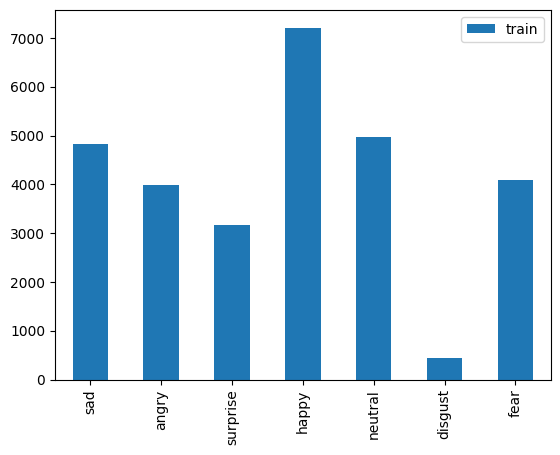

In [ ]:
train_count.transpose().plot(kind='bar')

<Axes: >

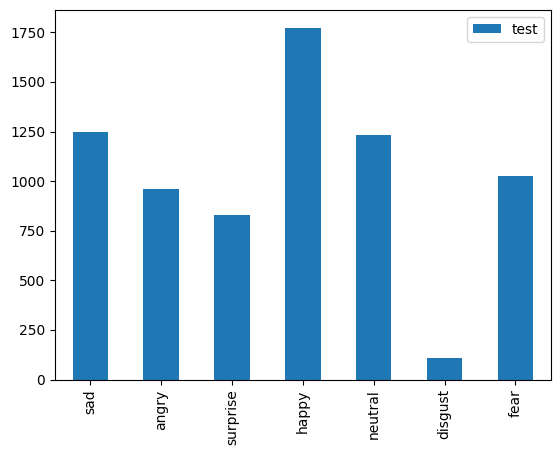

In [ ]:
test_count.transpose().plot(kind='bar')

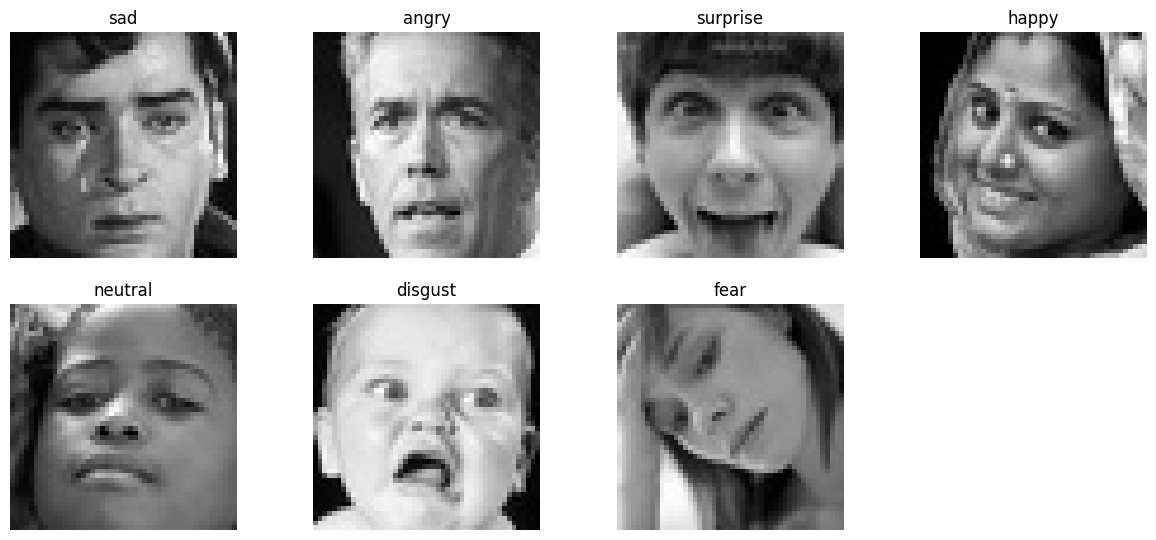

In [ ]:
import os
import matplotlib.pyplot as plt

# Replace with the actual path to your training data
train_dir = '/content/train'

emotions = os.listdir(train_dir)

plt.figure(figsize=(15, 10))

for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_dir, emotion)
    # Handle potential cases where a folder might be empty
    if os.listdir(folder):
        img_path = os.path.join(folder, os.listdir(folder)[0])
        img = plt.imread(img_path)
        plt.subplot(3, 4, i)
        plt.imshow(img, cmap='gray')
        plt.title(emotion)
        plt.axis('off')

plt.show()

# checking the shapes and channels

In [ ]:
image = '/content/train/angry/Training_10118481.jpg'
img = cv2.imread(image)

if img is not None:
  img.shape

In [ ]:
import cv2

image_path = '/content/train/angry/Training_10118481.jpg'
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

if img is not None:
  print(f'Image shape: {img.shape}')
else:
  print('Image could not be read.')

Image shape: (48, 48)


# Model 1: Custom CNN from Scratch



In [ ]:
#define the paths to the train and validation directories

train_data_dir = '/content/train'
test_data_dir = '/content/test'

img_width = img_height = 48
batch_size = 64
epochs = 10

num_classes = 7

In [ ]:
# rescale the pixel values (0-255 ) to the [0,1]

data_generator = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode ='grayscale',
    subset = 'training')

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode ='grayscale',
    subset = 'validation')

test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode ='grayscale')



Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
# Accessing class labels for training data

train_class_labels = train_generator.class_indices
print(f'Training class labels:', train_class_labels)

validation_class_labels = validation_generator.class_indices
print(f'Validation class labels:', validation_class_labels)

test_class_labels = test_generator.class_indices
print(f'Validation class labels: ' , test_class_labels)

print(type(train_generator))
print(type(validation_generator))
print(type(test_generator))


Training class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation class labels:  {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
<class 'keras.src.preprocessing.image.DirectoryIterator'>
<class 'keras.src.preprocessing.image.DirectoryIterator'>
<class 'keras.src.preprocessing.image.DirectoryIterator'>


In [ ]:
# Initialising the CNN
model = Sequential()

# Adding Convolutional layers with activatoin on the same line for clearity
model.add(Conv2D(32, kernel_size=(3, 3),kernel_initializer='glorot_uniform', padding='same', input_shape=(img_width, img_height, 1)))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size = (3,3), padding= 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size = (3,3), padding= 'same', kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(256, kernel_size = (3,3), padding= 'same', kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size = (3,3), padding='same', kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(512, kernel_size = (3,3), padding='same', kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

# Flattening and adding dense layers

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(num_classes))
model.add(Activation('softmax'))


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 activation_8 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 activation_9 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 batch_normalization_3 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                 

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 activation_8 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 activation_9 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 batch_normalization_3 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                 

# Understanding Callbacks

In [ ]:
cnn_path = '/content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch'
name = 'Custom_CNN_From_Scratch'
chk_path = os.path.join(cnn_path, name)
chk_path

'/content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_From_Scratch'

In [ ]:
checkpoint = ModelCheckpoint(
    filepath = chk_path,
    monitor = 'val_loss',
    verbose = 1,
    mode = 'min',
    save_best_only = True
)


In [ ]:
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    restore_best_weights=True,
)

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=1,
    verbose=1,
    min_delta=0.0001)

In [ ]:
csv_logger = CSVLogger(
    os.path.join(cnn_path, 'training.log')
)

In [ ]:
callbacks: list = [checkpoint, earlystop, reduce_lr, csv_logger]

# Calculating Steps for epoch

In [ ]:
train_generator.samples

22968

In [ ]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_per_epoch = validation_generator.samples // validation_generator.batch_size +1
test_steps_per_epoch = test_generator.samples // test_generator.batch_size + 1

# Model training

In [ ]:
history = model.fit (
    train_generator,
    steps_per_epoch = train_steps_per_epoch,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps_per_epoch,
    callbacks = callbacks
)

Epoch 1/10
359/359 [==============================] - ETA: 0s - loss: 12.1577 - accuracy: 0.3108
Epoch 1: val_loss improved from inf to 13.42749, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_From_Scratch
359/359 [==============================] - 43s 92ms/step - loss: 12.1577 - accuracy: 0.3108 - val_loss: 13.4275 - val_accuracy: 0.1787 - lr: 1.0000e-04
Epoch 2/10
359/359 [==============================] - ETA: 0s - loss: 9.5440 - accuracy: 0.3968
Epoch 2: val_loss improved from 13.42749 to 8.84315, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_From_Scratch
359/359 [==============================] - 29s 81ms/step - loss: 9.5440 - accuracy: 0.3968 - val_loss: 8.8431 - val_accuracy: 0.4172 - lr: 1.0000e-04
Epoch 3/10
359/359 [==============================] - ETA: 0s - loss: 7.3278 - accuracy: 0.4504
Epoch 3: val_loss improved from 8.84315 to 6.47630, saving model to /content/FER_2013_Emotion_Detection/Cus

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 4s 31ms/step - loss: 1.8357 - accuracy: 0.5875
final train accuracy = 77.43 , validation accuracy = 58.75


113/113 [==============================] - 6s 49ms/step


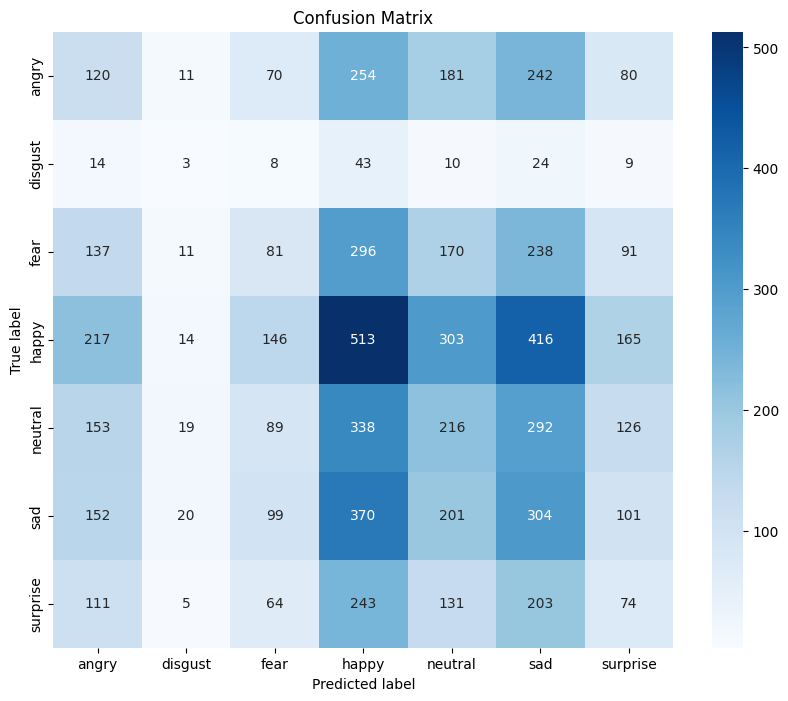

In [ ]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Printing the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.13      0.13      0.13       958
     disgust       0.04      0.03      0.03       111
        fear       0.15      0.08      0.10      1024
       happy       0.25      0.29      0.27      1774
     neutral       0.18      0.18      0.18      1233
         sad       0.18      0.24      0.20      1247
    surprise       0.11      0.09      0.10       831

    accuracy                           0.18      7178
   macro avg       0.15      0.15      0.14      7178
weighted avg       0.18      0.18      0.18      7178

